In [1]:
# for numerical analysis and data processing
import numpy as np
import pandas as pd
import itertools

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

# for Machine learning algorithms
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cdist

# for vizualizations
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
df = df = pd.read_csv("Cleaned_loan.csv", low_memory =False)
min_rate= df['int_rate'].min()
max_rate= df['int_rate'].max()
print(min_rate, max_rate, max_rate- min_rate)

5.32 28.99 23.669999999999998


In [3]:
df_max = df.max()
df_min = df.min()

df=(df-df.min())/(df.max()-df.min())

In [4]:
df = df.iloc[np.random.permutation(len(df))]

In [5]:
y = df.iloc[:,df.columns.isin(["int_rate"])]
x = df.loc[:,~df.columns.isin(["int_rate"])]

total_samples=len(df)
split = 0.8

x_train = x[0:int(total_samples*split)]
x_test = x[int(total_samples*split):total_samples]
y_train = y[0:int(total_samples*split)]
y_test = y[int(total_samples*split):total_samples]

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    '''
    Calculates mean absolute error of the true and predicted values.
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    count = 0
    sum = 0
    for a, p in zip(y_true, y_pred):
        if(a!=0):
            sum+=(abs(a-p)/a)
            count+=1
    return (sum/count) * 100

def view_metrics(y_test, predictions, algorithm, samples, total_samples):
    '''
    Plots the true and predicted values and prints RMS, MAE and MAPE metrics.
    '''
    fig = plt.figure(figsize=(18,5))
    plt.scatter(x=[i for i in range(samples)], y=[x for x in predictions[0:samples]], label='Predicted values')
    plt.scatter(x=[i for i in range(samples)], y=[x[0] for x in y_test.values[0:samples]], label='True values')
    plt.title('True and Predicted values for test dataset - %s' % algorithm)
    plt.legend()
    plt.show()
    
#     fig = plt.figure(figsize=(18,5))
#     plt.scatter(x=[i for i in range(total_samples)], y=[x for x in predictions], label='Predicted values')
#     plt.scatter(x=[i for i in range(total_samples)], y=[x[0] for x in y_test.values], label='True values')
#     plt.title('True and Predicted values for test dataset - %s' % algorithm)
#     plt.legend()
#     plt.show()

    RMS =  np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
    MAE = mean_absolute_error(y_test, predictions, multioutput='raw_values')
    MAPE = mean_absolute_percentage_error(y_test, predictions)
    print("Root Mean Squared Error:", RMS)
    print("Mean Absolute Error", MAE) 
    print("Mean Absolute Percentage Error", MAPE)
    return RMS, MAE, MAPE

# 1. Random Forest

##### max_depth itself states that the max depth of tree is 5. if not specified then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

##### min_samples_split : int, float, optional (default=2)

##### The minimum number of samples required to split an internal node:

##### If int, then consider min_samples_split as the minimum number.

##### If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
 

In [9]:
rand_forest_model = RandomForestRegressor(max_depth = 50 , n_estimators=20 ,random_state=0) # build model
rand_forest_model = rand_forest_model.fit(x_train, y_train.values.ravel()) # train model
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0,  n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
feature_importance = rand_forest_model.feature_importances_
R2 = rand_forest_model.score(x_train, y_train) # coefficient of determination
rand_forest_model_predictions = rand_forest_model.predict(x_test) # make predictions

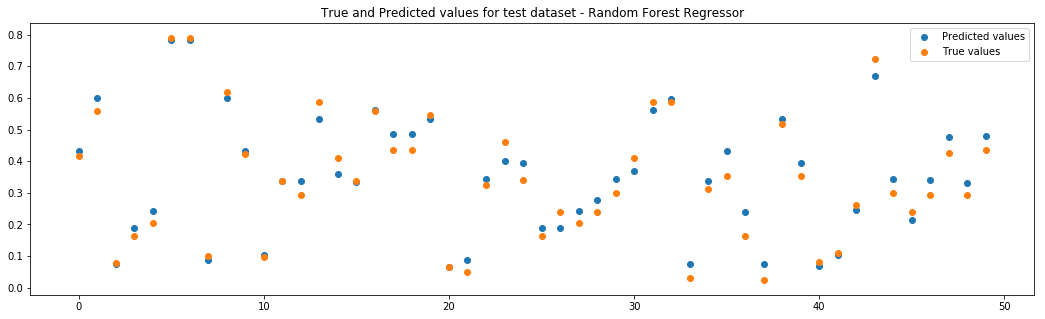

Root Mean Squared Error: [0.04161407]
Mean Absolute Error [0.03435454]
Mean Absolute Percentage Error [18.13900258]


In [8]:
rand_forest_model_metrics = view_metrics(y_test, rand_forest_model_predictions,'Random Forest Regressor', samples = 50, total_samples=2000)

In [10]:
#[estimator.tree_.max_depth for estimator in rand_forest_model.estimators_]
n_estimators = rand_forest_model.estimators_
n_estimators

[DecisionTreeRegressor(criterion='mse', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=209652396, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=398764591, splitter='best'),
 DecisionTreeRegressor(criterion='mse', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=924231285, splitter='best'),
 DecisionTreeRegressor(crite

# 2. Artificial Neural Network
##### (i) Learning Rate -  {‘constant’, ‘invscaling’, ‘adaptive’}, default ‘constant’

##### (ii) Optimizers - 
     
     a. Grid Search Parameter Tuning - methodically builds and evaluate a model for each combination of algorithm parameters    specified in a grid
     
     b. Random Search Parameter Tuning - samples algorithm parameters from a random distribution (i.e. uniform) for a fixed number of iterations. A model is constructed and evaluated for each combination of parameters chosen.

##### (iii) The number of epochs is determined by the maximum number of iterations (max_iter). The solver iterates until convergence (determined by ‘tol’) or this number of iterations

In [11]:
nn_model = MLPRegressor(hidden_layer_sizes=(10,4),
                                    activation='relu', # activation function in the nodes of the neral net
                                    solver='adam', # optimizer algorithm
                                    learning_rate='adaptive',
                                    learning_rate_init=0.001, # initial learning rate
                                    max_iter=200, # max iterations to train for
                                    tol = -1, # tolerance for when to stop training should be range 0.001 to 0.0000001, -1 for max_iter
                                    shuffle=True,
                                    verbose=True) # show details at each iteration
nn_model = nn_model.fit(x_train, y_train.values.ravel())

Iteration 1, loss = 0.00322028
Iteration 2, loss = 0.00101344
Iteration 3, loss = 0.00094342
Iteration 4, loss = 0.00087050
Iteration 5, loss = 0.00074764
Iteration 6, loss = 0.00060277
Iteration 7, loss = 0.00050660
Iteration 8, loss = 0.00045441
Iteration 9, loss = 0.00042355
Iteration 10, loss = 0.00040208
Iteration 11, loss = 0.00038692
Iteration 12, loss = 0.00036944
Iteration 13, loss = 0.00034243
Iteration 14, loss = 0.00031243
Iteration 15, loss = 0.00028447
Iteration 16, loss = 0.00026900
Iteration 17, loss = 0.00026417
Iteration 18, loss = 0.00026091
Iteration 19, loss = 0.00025619
Iteration 20, loss = 0.00025494
Iteration 21, loss = 0.00025314
Iteration 22, loss = 0.00025028
Iteration 23, loss = 0.00024897
Iteration 24, loss = 0.00024499
Iteration 25, loss = 0.00024341
Iteration 26, loss = 0.00024197
Iteration 27, loss = 0.00024039
Iteration 28, loss = 0.00023767
Iteration 29, loss = 0.00023586
Iteration 30, loss = 0.00023585
Iteration 31, loss = 0.00023359
Iteration 32, los

C:\Users\bhavy\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


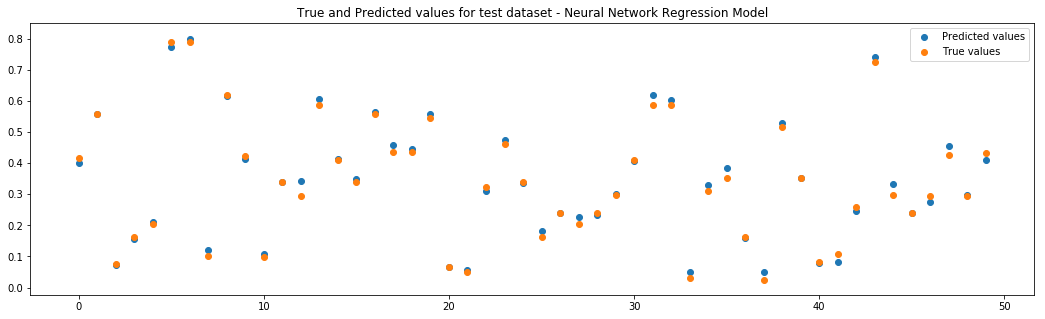

Root Mean Squared Error: [0.01778292]
Mean Absolute Error [0.01289416]
Mean Absolute Percentage Error [6.90784192]


In [12]:
nn_model_predictions = nn_model.predict(x_test)
nn_model_metrics = view_metrics(y_test, nn_model_predictions,'Neural Network Regression Model', samples = 50, total_samples=2000)

# 3. Linear Regression
A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

The key difference between these two is the penalty term.

##### (i) Ridge Regression - Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.

In [14]:
from sklearn.linear_model import Ridge

# Ridge Regression Model
rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
rr.fit(x_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

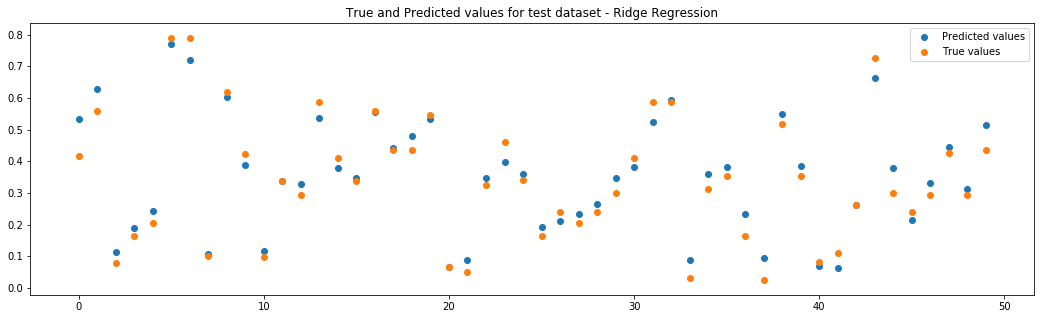

Root Mean Squared Error: [0.04649018]
Mean Absolute Error [0.03726418]
Mean Absolute Percentage Error [20.55064082]


In [15]:
rid_reg_model_predictions = rr.predict(x_test) # make predictions
rid_reg_model_metrics = view_metrics(y_test, rid_reg_model_predictions,'Ridge Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.

##### (ii) Lasso Regression - (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

In [24]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
train_score=lasso.score(x_train, y_train)

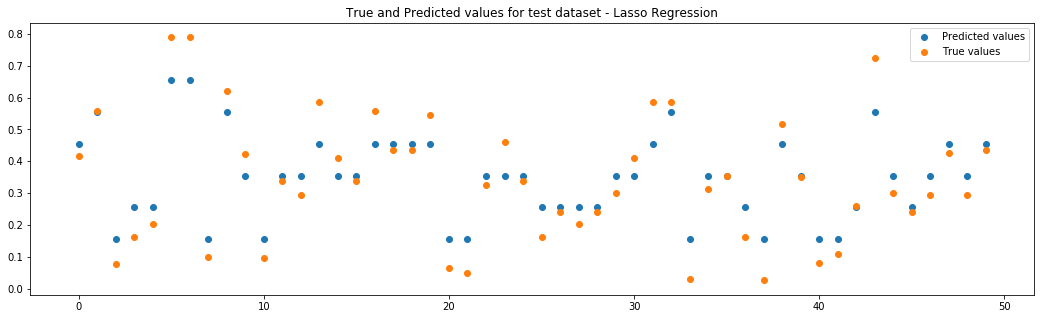

Root Mean Squared Error: [0.07201117]
Mean Absolute Error [0.05776132]
Mean Absolute Percentage Error [36.96038408]


In [25]:
las_reg_model_predictions = lasso.predict(x_test) # make predictions
las_reg_model_metrics = view_metrics(y_test, las_reg_model_predictions,'Lasso Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.

##### (iii)Elastic Net Regression - regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods

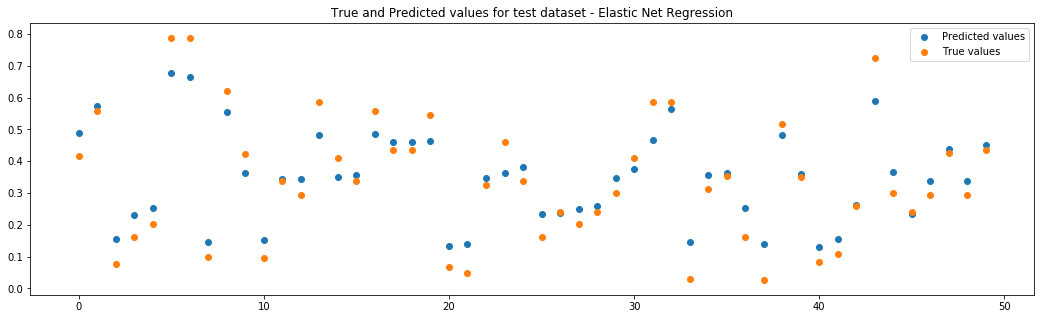

Root Mean Squared Error: [0.06375659]
Mean Absolute Error [0.05103332]
Mean Absolute Percentage Error [32.89731126]


In [26]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.01)
elastic.fit(x_train, y_train)

elas_reg_model_predictions = elastic.predict(x_test) # make predictions
las_reg_model_metrics = view_metrics(y_test, elas_reg_model_predictions,'Elastic Net Regression', samples = 50, total_samples=2000)
## If predicted value is same as true value, the points will be overlapping. Closer the points, better is the prediction.